# Under the hood of CNNs

Convolution of 2D finite elements is defined as:

$(I * K)(i, j) = \sum_m \sum_n I(m, n) K(i - m, j - n)$



In practice, this means that we loop over each element of the input image and return the dot product of the kernel and the corresponding patch of image around the current pixel.

In pytorch, this is implemented in `torch.nn.Conv2d`.

```python
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
```

The kernel size determines the size of the patch of image that is used to compute the dot product. In this case, the kernel size is 3, so the patch of image is 3x3.

In [1]:
import numpy as np
from scipy import ndimage, signal
from IPython.display import HTML
import matplotlib.pyplot as plt

from ttt_workshop_cnn import utils

(np.float64(-0.5), np.float64(13.5), np.float64(13.5), np.float64(-0.5))

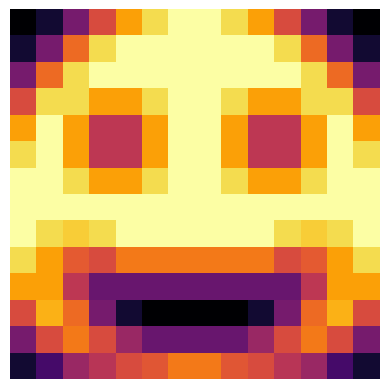

In [2]:
smiley = utils.draw_smiley()
kernel = utils.draw_gaussian_kernel(size=3, sigma=1)

output = np.zeros((smiley.shape[0] - kernel.shape[0] + 1, smiley.shape[1] - kernel.shape[1] + 1))
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
            output[i, j] = np.sum(smiley[i:i+kernel.shape[0], j:j+kernel.shape[1]] * kernel)

# scipy.signal.correlate implements the convolution operation
# you could also use scipy.ndimage.convolve, but this always uses padding (see below)
output = signal.correlate(smiley, kernel, mode="valid")
plt.imshow(output, cmap='inferno')
plt.axis('off')

Here is a nice animation that illustrates the algorithm:

In [3]:
animation = utils.animate_convolution(smiley, kernel, interval=200); HTML(animation.to_jshtml())

Note how the output is smaller than the input. This can be avoided using padding

## Padding keeps input and output dimensions identical


We can add a border of pixels around the input image. The number of pixels to add depends on the kernel size. For a kernel of size $k \times k$, we need to add $\frac{k-1}{2}$ pixels on each side (assuming $k$ is odd).

For example, for a $3 \times 3$ kernel, we add 1 pixel on each side. For a $5 \times 5$ kernel, we add 2 pixels on each side.

In PyTorch, this is done by specifying the `padding` argument in `torch.nn.Conv2d`.

```python
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
```

The values of the added pixels can be set in different ways. The most common are:

- **Constant padding**: Adds a constant value (e.g., 0) to all borders.
- **Reflective padding**: Mirrors the border pixels.
- **Replicate padding**: Repeats the edge pixels.

```python
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, padding_mode='reflect')
```
```python
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, padding_mode='replicate')
```
```python
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, padding_mode='constant')
```

### Padding mode `constant`

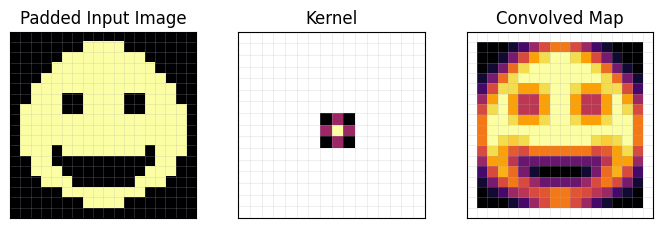

In [4]:
padded_smiley = np.pad(smiley, pad_width=1, mode='constant', constant_values=0); _ = utils.plot_input_kernel_output(padded_smiley, kernel, titles=("Padded Input Image", "Kernel", "Convolved Map"))

(np.float64(-0.5), np.float64(15.5), np.float64(15.5), np.float64(-0.5))

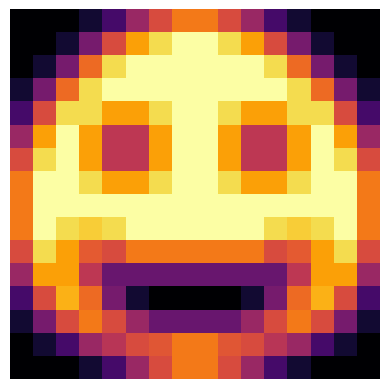

In [5]:
# this is equivalent to:
output = ndimage.convolve(smiley, kernel, mode='constant', cval=0.0)  # with zero padding
plt.imshow(output, cmap='inferno')
plt.axis('off')

### Padding mode `reflect`

Reflects the input at the edge. Sometimes causes less artefacts when used in CNNs.

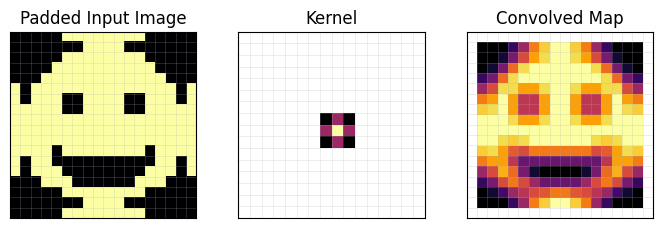

In [6]:
padded_smiley = np.pad(smiley, pad_width=1, mode='reflect'); _ = utils.plot_input_kernel_output(padded_smiley, kernel, titles=("Padded Input Image", "Kernel", "Convolved Map"))

### Padding mode `edge`

Repeats the edge value.

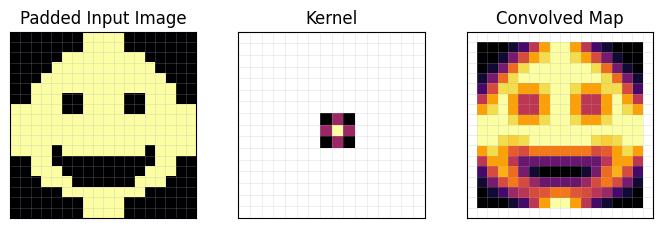

In [7]:
padded_smiley = np.pad(smiley, pad_width=1, mode="edge"); _ = utils.plot_input_kernel_output(padded_smiley, kernel, titles=("Padded Input Image", "Kernel", "Convolved Map"))

## Stride determines how far the kernel moves between iterations

A stride of 2 processes only every other pixel (in both x and y dimensions). Therefore, the output has only half the size in each dimension (a quarter of the total number of pixels).

In PyTorch, this is done by specifying the `stride` argument in `torch.nn.Conv2d`.

```python
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
```

An alternative way to achieve the same effect is to use a pooling layer after the convolution. Pooling layers reduce the spatial dimensions of the input by taking the maximum or average value in a local neighborhood.

```python
pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
```

A common pattern is to use a convolution with stride 1 followed by a pooling layer with stride 2. As the image is downsampled, the number of channels is usually increased to retain sufficient information.

(np.float64(-0.5), np.float64(6.5), np.float64(6.5), np.float64(-0.5))

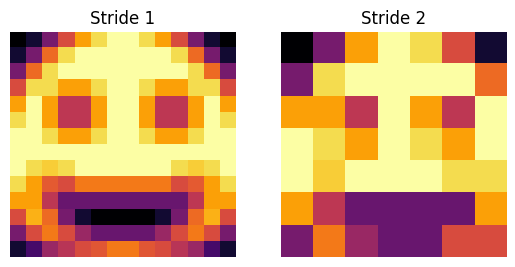

In [8]:
# for loops with stride
stride = 2
output = np.zeros(( (smiley.shape[0] - kernel.shape[0]) // stride + 1, (smiley.shape[1] - kernel.shape[1]) // stride + 1))
for i in range(0, output.shape[0]):
    for j in range(0, output.shape[1]):
        output[i, j] = np.sum(smiley[i*stride:i*stride+kernel.shape[0], j*stride:j*stride+kernel.shape[1]] * kernel)
#Plot stride 1 and 2 results side by side
plt.subplot(1, 2, 1)
plt.imshow(signal.correlate(smiley, kernel, mode="valid"), cmap='inferno')
plt.title("Stride 1")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output, cmap='inferno')
plt.title("Stride 2")
plt.axis('off')

In [9]:
# animation = utils.animate_convolution(padded_smiley, utils.draw_sobel_kernel(), stride=2, interval=200); HTML(animation.to_jshtml())

## $n$ kernels create $n$ feature maps

A kernel is almost never used alone in a CNN. Instead, multiple kernels are used in parallel to create multiple feature maps. The number of kernels is also called the number of output channels.

This enables the network to learn multiple features in parallel. For example, one kernel could learn to denoise the image (Gaussian), another kernel could detect edges (Laplacian), and a third kernel could detect horizontal edges (Sobel).

Inn a CNN, the kernels are learned during training. The kernels are initialized randomly and then updated using backpropagation.

In pytorch, this is done by specifying the `out_channels` argument in `torch.nn.Conv2d`.

```python
conv = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)

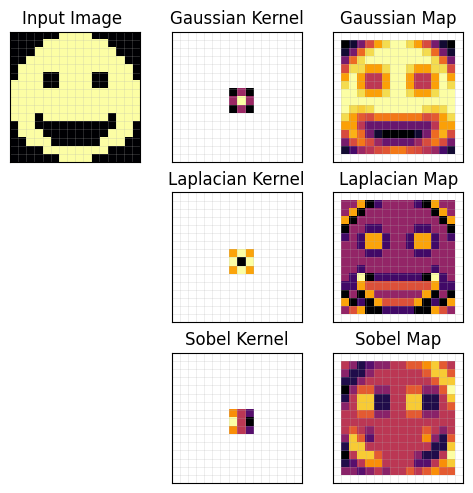

In [10]:
_ = utils.plot_three_kernels(smiley, [kernel, utils.draw_laplacian_kernel(), utils.draw_sobel_kernel()])

## The receptive field limits the amount of context a CNN can learn

The largest object that can be "seen" by a neuron in a CNN is called its **receptive field** (sometimes also called perceptive field). For example, a neuron with a receptive field of 128 pixels could not recognize a car that is 1024 pixels large, but it would recognize edetails like for example the wheels, mirrors and door handles.

For a single convolutional layer, the receptive field is equal to the kernel size. For example, a $3 \times 3$ kernel has a receptive field of 3 pixels, a $5 \times 5$ kernel has a receptive field of 5 pixels, and so on.

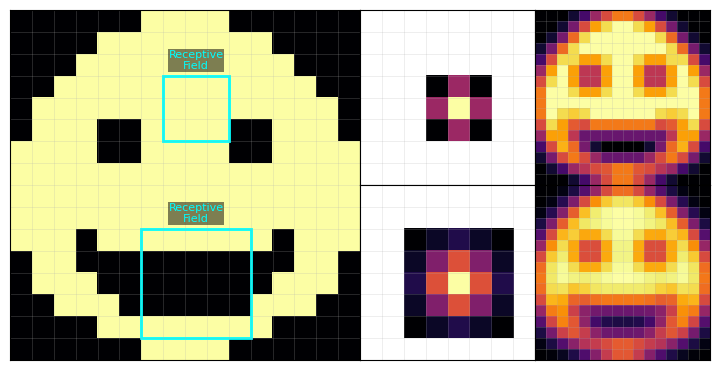

In [11]:
utils.plot_receptive_field(smiley, kernel_layers=1, kernel_sizes=(3,5))

### Receptive fields of consecutive layers stack up

When multiple convolutional layers are stacked, the receptive field increases. For example, two $3 \times 3$ convolutional layers have a receptive field of 5 pixels, because the first layer sees 3 pixels, and the second layer sees 3 pixels of the output of the first layer, which corresponds to 5 pixels of the input image.


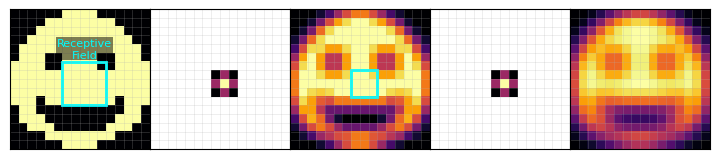

In [12]:
utils.plot_receptive_field(smiley, kernel_layers=2, kernel_sizes=(3,))

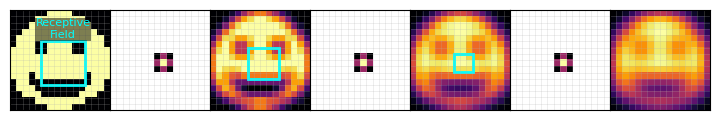

In [13]:
utils.plot_receptive_field(smiley, kernel_layers=3, kernel_sizes=(3,))


### Adding 3x3 layers is more parameter efficient than increasing kernel size

|Receptive field   | Larger Kernel         | Multiple 3x3 kernels          |
|-------------------|-----------------------|-------------------------------|
| 5 x 5             | $5^2 = 25$ parameters | $2 \cdot 3^2 = 18$ parameters |
| 7 x 7             | $7^2 = 49$ parameters | $3 \cdot 3^2 = 27$ parameters |
| **scaling:**       | **quadratic**         | **linear**                    |

Increasing the receptive field by increasing kernel size scales quadratically, while adding 3x3 layers scales linearly. Therefore, most modern CNNs almost exclusively use 3x3 layers.

### Calculating the receptive field of a CNN

The receptive field depends on the kernel size and stride of all preceding layers. For example, a single 5x5 convolutional layer has a receptive field of 5x5 pixels. Two consecutive 3x3 convolutional layers have a receptive field of 5x5 pixels as well (3 + 2 = 5). Three consecutive 3x3 convolutional layers have a receptive field of 7x7 pixels (3 + 2 + 2 = 7). Note that the receptive field grows by `kernel size - 1` pixels for each additional layer (i.e. 2 pixels for each 3x3 kernel layer or 4 pixels for each 5x5 kernel layer). Each pooling layer doubles the receptive field.



### Example Receptive field of a CNN

For example, a CNN with the following architecture has a receptive field of 32x32 pixels:

* 3x3 kernel, receptive field 3x3
* 3x3 kernel, receptive field 5x5
* 2x2 pooling, receptive field 10x10
* 3x3 kernel, receptive field 12x12
* 3x3 kernel, receptive field 14x14
* 2x2 pooling, receptive field 28x28
* 3x3 kernel, receptive field 30x30
* 3x3 kernel, receptive field 32x32


## Summary

* Padding keeps input and output dimensions identical
* Stride determines how far the kernel moves between iterations
* n kernels create n feature maps
* The Receptive field limits the amount of context a CNN can learn
  * Deeper networks have larger receptive fields
    * Add kernel size - 1 for each additional layer
    * Multiply by Stride (or pooling)